# Домашнее задание 2 - Локализация ключевых точек
<br>

Задание выполнил(а): *Телегина Анна Дмитриевна, 524 группа*
<br>

**Дедлайн:** 26.04.2021 23:59


### О задании
В этом задании вы познакомитесь с функционалом SAS для реализации сетей локализации ключевых точек, а так же построите и обучите такую сеть самостоятельно.
<br>

**Задание построено следующим образом:**<br>
1) Задание 1: Загрузка данных в CAS - 1 балл<br>
2) Задание 2: Соединение таблиц - 3 балла<br>
3) Задание 3: Подготовка данных для обучения - 2 балла<br>
4) Задание 4: Построение модели - 4 балла<br>
5) Задание 5: Обучение модели - 2 балла<br>
6) Задание 6: Проверка и визуализация результатов работы сети - 3 балла<br>
7) Задание 7 (дополнительное) - до +2 баллов

### Формат сдачи

После того, как вы выполните домашную работу, поместите jupyter notebook с выполнеными заданиями (output всех ячеек должен сохранится) в закрытый git-репозиторий на GitHub. Предоставьте доступ к репозиторию аккаунтам GazizovMarat и Ala1s (добавив в свой репозиторий в качестве коллабораторов).

### Важно 
Для того, чтобы ваши результаты были воспроизводимыми для проверки, указывайте seed при вызове методов, где это возможно. Напоминания об этом так же содержатся в тексте заданий.

In [1]:
import os
import numpy as np
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

from glob import glob
from tqdm import tqdm

from swat import *
from dlpy import Model, Sequential
from dlpy.layers import *
from dlpy.images import ImageTable
from dlpy.splitting import three_way_split

**Подключение к серверу CAS**<br>
Подключитесь к серверу CAS под своим логином и паролем.<br>
Загрузите следующие Action Sets: 'image' и 'deepLearn'.<br>

In [2]:
#os.environ['CAS_CLIENT_SSL_CA_LIST'] = r"/tmp/4fix/trustedcerts.pem"

# Создаем новую сессию CAS:

s = CAS("tiger.cs.msu.ru", 5570, username='msu108', password="BabBage-8o")

# Загружаем action sets:

s.loadactionset("image")
s.loadactionset("deepLearn")
s.loadactionset("datastep")

NOTE: Added action set 'image'.
NOTE: Added action set 'deepLearn'.
NOTE: Added action set 'datastep'.


[actionset]

 'datastep'

+ Elapsed: 0.000446s, user: 0.000213s, sys: 0.000156s, mem: 0.203mb

**Набор данных**<br>
Вам предлагается набор данных с фотографиями кошек. Сами фотографии располагаются в папке images. Для каждой фотографии имеется разметка, содержащяя координаты 9 ключевых точек мордочки кошки, точки в разметке представлены через пробел в следующем порядке:
- Number of points (default is 9)
- Left Eye
- Right Eye
- Mouth
- Left Ear-1
- Left Ear-2
- Left Ear-3
- Right Ear-1
- Right Ear-2
- Right Ear-3

<br>
Пример изображения:<br>

![cat](cat1.PNG)

<br>
Первое число - количество точек, оно нам не потребуется.<br>
Разметка для каждого изображения находится в отдельном файле, все эти файлы с разметкой содержатся в папке points. Название каждого такого файла совпадает с названием изображения, но имеют расширение '.cat', но не переживайте - это простые текстовые файлы. <br>
Пример:<br>
Название файла изображения - 00000001_000.jpg <br>
Название файла с разметкой - 00000001_000.jpg.cat

**Задание 1: Загрузка данных в CAS**<br><br>
a) Перед тем, как использовать набор данных, потребуется решить несколько проблем с ним. <br><br>
Во-первых, для того чтобы загрузить разметку в CAS потребуется сформировать из них таблицу. Дополните код ниже, чтобы сделать это. <br><br>
Заметьте, что одна из строчек кода, уже написанного за вас, помогает отсеивать разметку, в которой не все ключевые точки присутствуют на изображении - в таком случае в разметке присутствуют отрицательные числа. Такие примеры нам не потребуются, поэтому код, сохраняющий разметку для изображений, напишите внутри этого блока if.

In [3]:
points_data = []
a_path = "cats/points/*.cat"
for path in glob(a_path):
    with open(path,'r') as f:
        points = f.read().split(' ')[1:-1]
        points = [int(x) for x in points]
        if any(x<0 for x in points) == False:
            fil = path[:len(path)-4].replace("points", 'images')
            points_data.append([fil] + points)

In [4]:
labels = ['_filename_0',
'left_eye_x','left_eye_y',
'right_eye_x','right_eye_y',
'mouth_x','mouth_y',
'left_ear1_x','left_ear1_y',
'left_ear2_x','left_ear2_y',
'left_ear3_x','left_ear3_y',
'right_ear1_x','right_ear1_y',
'right_ear2_x','right_ear2_y',
'right_ear3_x','right_ear3_y']

In [5]:
data = pd.DataFrame.from_records(points_data, columns=labels)

b) Также, все координаты ключевых точек указаны в абсолютных коорданатах - соотвественно, если мы изменим размер изображения, координаты ключевых точек придётся пересчитывать. Давайте переведем их в относительные координаты - для этого потребуется поделить координаты по x на ширину изображения, а координаты по y на высоту изображения. Обратите внимание, что все изображения различного размера. Также обратите внимание на тип данных столбцов в dataframe - если тип целочисленный, то посчитанные вами значения будут округляться к нулю или единице, что, конечно же, неверно.  

In [6]:
data.loc[0, :]

_filename_0     cats/images/00000001_000.jpg
left_eye_x                               175
left_eye_y                               160
right_eye_x                              239
right_eye_y                              162
mouth_x                                  199
mouth_y                                  199
left_ear1_x                              149
left_ear1_y                              121
left_ear2_x                              137
left_ear2_y                               78
left_ear3_x                              166
left_ear3_y                               93
right_ear1_x                             281
right_ear1_y                             101
right_ear2_x                             312
right_ear2_y                              96
right_ear3_x                             296
right_ear3_y                             133
Name: 0, dtype: object

In [7]:
n = data.shape[0]

for i in range(n):
    pic = data.loc[i, "_filename_0"]
    h, w, c = cv2.imread(pic).shape
    for j in data.loc[i, :].index:
        if j[-2:] == "_0":
            continue
        elif j[-2:] == "_x":
            data.loc[i, j] /= float(w)
            #print(data.loc[i,j])
        else:
            data.loc[i, j] /= float(h)

In [8]:
data["_filename_0"] = data["_filename_0"].apply(lambda x: x[12:])

c) Сохраните набор данных в формате csv, а затем загрузите эту таблицу в CAS с помощью функции upload_file.

In [9]:
data.to_csv("dataset2.csv")

In [10]:
data_table = s.upload_file("dataset2.csv")

NOTE: Cloud Analytic Services made the uploaded file available as table DATASET2 in caslib CASUSER(msu108).
NOTE: The table DATASET2 has been created in caslib CASUSER(msu108) from binary data uploaded to Cloud Analytic Services.


d) Создайте список названий переменных, в которых лежат координаты ключевых точек - он нам понадобится в дальнейшем.

In [11]:
variables = [
                'left_eye_x','left_eye_y',
                'right_eye_x','right_eye_y',
                 'mouth_x','mouth_y',
                'left_ear1_x','left_ear1_y',
                'left_ear2_x','left_ear2_y',
                'left_ear3_x','left_ear3_y',
                'right_ear1_x','right_ear1_y',
                'right_ear2_x','right_ear2_y',
                'right_ear3_x','right_ear3_y'
            ]

e) Загрузите изображения из папки images в ImageTable.

In [12]:
images = ImageTable.load_files(s, "/var/home/msu108/SAS-CV-2020-Homework2/cats/images")

**Задание 2: Соединение таблиц**<br><br>
a) Соедините таблицу с изображениями и таблицу с казметкой с помощью action dlJoin. 
b) Затем с помощью конструктора ImageTable.from_table превратите уже соединенную таблицу в ImageTable для дальнейшей работы с ней.

In [13]:
# a)
points = s.dlJoin(annotatedTable=images, table=data_table, id="_filename_0", casOut={"name":"output"})["OutputCasTables"]["casTable"][0]

In [14]:
# b)
table = ImageTable.from_table(points, columns=variables)

**Задание 3: Подготовка данных для обучения**<br><br>
а) Измените размер изображений на 96x96 с помощью функции resize ImageTable.<br>
b) Перемешайте данные с помощью функции action shuffle.<br>
c) Разделите набор данных на обучающий, валидационный и тестовых с помощью функции three_way_split. Процент данных в валидационном наборе данных - 20%, в тестовом - 20%.<br>

In [15]:
# a)
table.resize(96, 96, columns=variables)

In [16]:
# b)
table_new = s.shuffle(table)["casTable"]

In [17]:
# c)
train, val, test = three_way_split(table_new, valid_rate=20, test_rate=20, im_table=False)

**Задание 4: Построение модели**<br><br>
Постройте модель CNN, схема которой изображена на картинке. Особенности модели не отраженные на рисунке: в слое Conv предшествующем BatchNormalization отсутствуют bias, а в Dense слое присутствует дропаут с вероятностью 0.2. Полученная вами сеть должна показывать Loss Error на тестовом наборе данных более 0.21.
![model](kpnetwork.PNG)

In [18]:
model = Sequential(s, model_table='cnn_model')
model.add(InputLayer(1,96,96,name="input"))
model.add(Conv2d(72, 4, 4))
model.add(Pooling(2, 2))
model.add(Conv2d(48, 2, 2, include_bias=False))
model.add(BatchNormalization())
model.add(Dense(48, dropout=0.2))
model.add(Keypoints(n=18, name='kp1'))

NOTE: Input layer added.
NOTE: Convolution layer added.
NOTE: Pooling layer added.
NOTE: Convolution layer added.
NOTE: Batch normalization layer added.
NOTE: Fully-connected layer added.
NOTE: Keypoints layer added.
NOTE: Model compiled successfully.


**Задание 5: Обучение модели**<br><br>
Обучите модель, дополнив код ниже. Формат входных данных в model.fit укажите с помощью параметра data_specs.

In [19]:
from dlpy.model import *
from dlpy.model import Optimizer

#Подберите самостоятельно
lr = 1e-3

optimizer = Optimizer(mini_batch_size=12, log_level=2, max_epochs=20, reg_l2=0.0005,
                      algorithm=MomentumSolver(clip_grad_max=1000, clip_grad_min=-1000,
                                               learning_rate=lr, step_size=30))

data_specs = [DataSpec(type_='IMAGE', layer='input', data=['_image_']), DataSpec(type_='numnom', layer='kp1', data=variables)]

In [23]:
train_history = model.fit(data=train, optimizer=optimizer, valid_table=val, data_specs=data_specs, seed=42)

NOTE: Training based on existing weights.
NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 5324490.
NOTE:  The approximate memory cost is 5153.00 MB.
NOTE:  Loading weights cost       0.05 (s).
NOTE:  Initializing each layer cost       0.53 (s).
NOTE:  The total number of threads on each worker is 40.
NOTE:  The total mini-batch size per thread on each worker is 12.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 480.
NOTE:  Number of input variables:     1
NOTE:  Number of numeric input variables:      1
NOTE:  Epoch Learning Rate        Loss  Fit Error  Validation Loss Validation Error   Time(s)
NOTE:  0         0.001          0.1805     0.3609           0.1803           0.3606    20.19
NOTE:  1         0.001          0.1798     0.3596           0.1784           0.3567    19.52
NOTE:  2         0.001          0.1714     0.3428           0.1767           0.3534    20.08
NOTE:  3         0.001          0.1708     0.3415     

**Задание 6: Проверка и визуализация результатов работы сети**<br><br>
a) Получите предсказания на тестовом наборе данных c помощью функции predict.<br>
b) Дополните код функции plot_landmarks, предназначенной для визуализации предсказаний модели. С помощью вызова этой функции отоборазите результаты из тестового набора данных.

In [24]:
# a)
tested = model.predict(test)

In [25]:
tested

[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read          1801
 1  Number of Observations Used          1801
 2           Mean Squared Error       0.34441
 3                   Loss Error      0.172205

[OutputCasTables]

             casLib              Name  Rows  Columns  \
 0  CASUSER(msu108)  Valid_Res_IkALa9  1801       40   
 
                                             casTable  
 0  CASTable('Valid_Res_IkALa9', caslib='CASUSER(m...  

+ Elapsed: 2.45s, user: 49.9s, sys: 4.64s, mem: 1.85e+03mb

In [26]:
# b)
def plot_landmarks(conn, data, targets, image_list=range(4), n_col=2, figsize=None):
    import cv2
    n_images = len(image_list)
    num_obs = min(len(data), n_images)
    res_img = conn.fetchimages(table=data, to=num_obs).Images
    res_label = conn.fetch(data, fetchvars=targets, to=num_obs).Fetch

    if n_images > n_col:
        n_row = n_images // n_col + 1
    else:
        n_row = 1
        n_col = n_images

    if figsize is None:
        figsize = (16, 16 // n_col * n_row)

    fig = plt.figure(figsize=figsize)

    idx_img = 1
    for i in image_list:
        img = res_img.loc[i, 'Image']
        img_arr = np.array(img)
        circle_size = int(min(img_arr.shape[:2])/40)
        for j in range(0, len(targets), 2):
            x = int(res_label.loc[i, targets[j]] * res_img.loc[i, 'Width'])
            y = int(res_label.loc[i, targets[j + 1]] * res_img.loc[i, 'Height'])
            cv2.circle(img_arr, (x, y), circle_size, (255, 0, 0), -1)
        ax = fig.add_subplot(n_row, n_col, idx_img)
        plt.imshow(img_arr, cmap='gray')
        idx_img += 1
        plt.xticks([]), plt.yticks([])
    plt.show()

NOTE: Table TEST_Q0UZAZ contains compressed images.


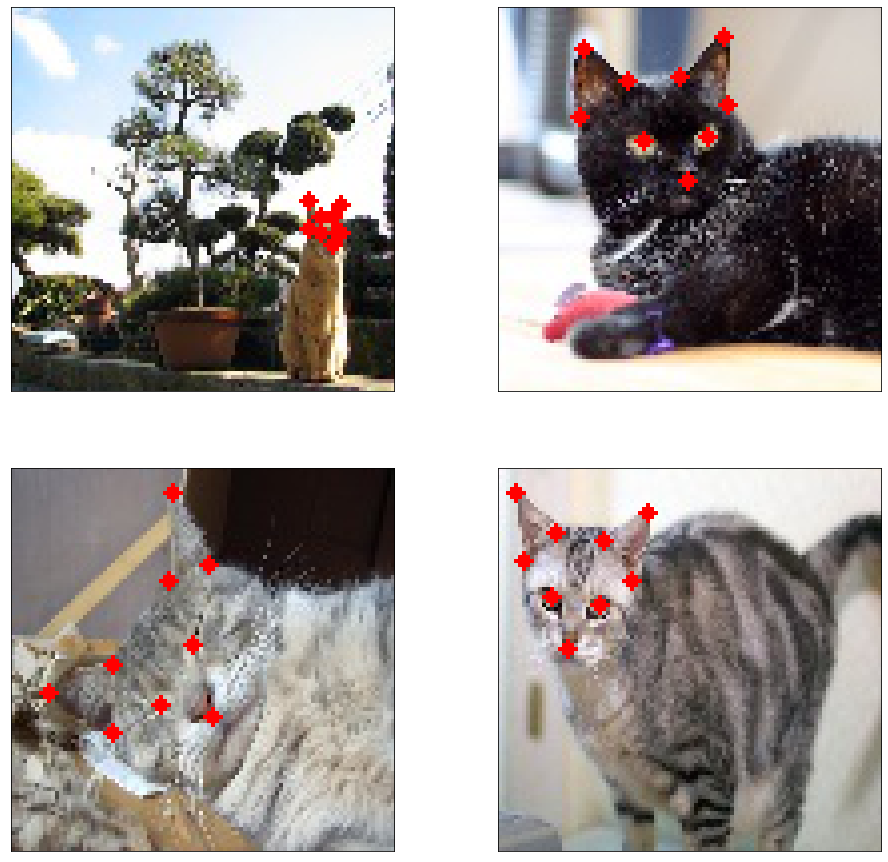

In [27]:
plot_landmarks(s, test, targets=variables)

**Задание 7 (дополнительное):**<br><br>
Перепишите функцию plot_landmarks так, чтобы различные ключевые точки отображались различными цветами. То есть, например, точка левого глаза всегда была синей, правого - зеленой и т.д.

In [ ]:
#Ваш код здесь